# Introduction

Computer vision has gained traction in the recent years because of its state of the art performance in tasks such as image classification, object detection, speech recognition and more. It has found application in wide fields and in this tutorial we are going to handle basic image classification


Image classification refers to a process in computer vision that classifies images according to its visual content e.g, an image classification algorithmn to indentify if an image contains a car or a truck.

This tutorial represents our hello world example and we will dive deeper as we proceed to other posts. You will learn how to develop models using TensorFlow 2.X, we will build a models using tf.keras.Sequatial and load data with tf.data api. 

The data used is furniture dataset from [kaggle](https://www.kaggle.com/akkithetechie/furniture-detector).

# Tutorial Overview
This tutorial is divided into seven parts namely;
- Data Understanding, Processing and Visualization
- Model Preparation
- Model Training 
- Model Performance Analysis
- Model conversion

Above represents the common procedure followed in a machine learning task. Without futher ado let's jump right in and start coding, enjoy.

# Handle Imports
Let's start by importing the necessary packages we will be using. TensorFlow 2.X is our main package for developing the model, os will be used to read data from the disk, matplotlib for visualization and numpy to perform some mathematical computations.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path
sns.set()

In [2]:
# Initialize parameters and dataset directories
# data directory
DATADIR  = "../../DATASETS/FUNITURE/"
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32

# Data Understanding, Processing and Visualization
To understand the kind of data we are dealing we need to visualize them but first we will build the dataset using tf.data api, lets start by creating helper functions

1. Reading images from disk
2. Getting data labels
3. Processing the data paths


In [3]:
# reading image from the disk
def read_image(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=CHANNELS)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    return img

In [4]:

# To get labels
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [5]:
# process paths
def process_path(file_path):
    label = get_label(file_path)
    img = read_image(file_path)
    return img, label

Using the above functions to process the data, We will use tf.data.Dataset.list_files to get the filenames then tf.Dataset.map function to map the above functions in order to get our images

In [6]:
# get class names
CLASS_NAMES = np.array([item.name for item in Path(DATADIR + "train").glob('*')])

# train data
train_list_ds = tf.data.Dataset.list_files(str(DATADIR + "train/" +'*/*'))
# validation data
val_list_ds = tf.data.Dataset.list_files(str(DATADIR + "val/" +'*/*'))

# map the functions
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

We will use tf.Dataset.map function to map the above functions in order to get our images

In [7]:
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

To visualize our dataset, we have to create a function to help visualize a batch of dataset. This will help acertain that the data we will be passing to the model is well 
formated. We will also have to prepare the data for training i.e  i.e it should be shuffled and repeat forever and also let it fetch batches in the background while the model is training.

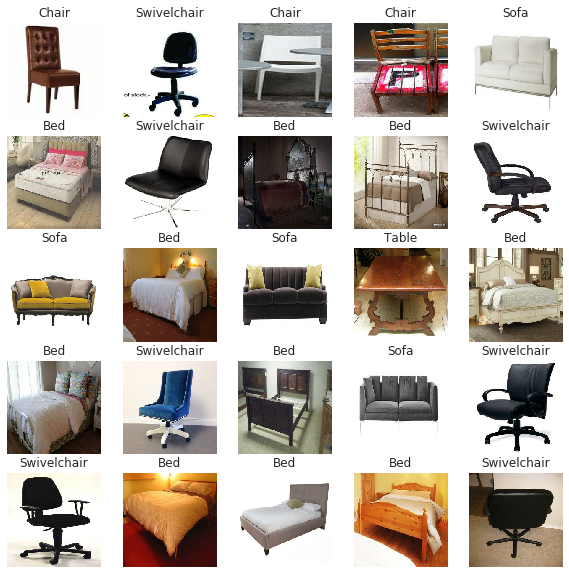

In [8]:
# a function to show the image batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

# prepare data for training 
def prepare_for_training(ds, shuffle_buffer_size=500, training=True):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=-1)

  return ds

train_ds = prepare_for_training(train_labeled_ds)
val_ds = prepare_for_training(val_labeled_ds, training=False)

# get a sample batch
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Model Preparation
Now that the data is well prepared and ready for training, we will head over and start building our model. As you know this is our first tutorial, will rock simple and use tf.keras.Sequential api which provides a simple models building process.

The model will consist of the following layers;
* Convolution - extracts features from a source image

* Maximum pooling - downsamples each feature to reduce its dimensionality and focus on the most important elements

* Global averaging -operation that calculates the average output of each feature map in the previous layer.

* Dense layer - last layer with softmax activation function to return probability of classes

later will compile the model with 
- *SparseCategoricalCrossentropy* loss - measures how accurate the model is during training

- *Adam* optimizer- how the model is updated and 
- *CategoricalAccuracy* -monitors the training and testing steps

In [9]:
def simple_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32 ,(3,3), activation="relu", 
                padding="same", input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

# Model Training 
It's time to start training by calling model.fit but first things first, we need calcuate  training steps and validation steps. Will also collect the traininig stats to perform analysis.

In [10]:
# get the number of images
train_image_count = len(list(Path(DATADIR + "train").glob('*/*')))
val_image_count = len(list(Path(DATADIR + "valid").glob('*/*')))

steps_per_epoch = train_image_count // BATCH_SIZE
validation_steps = val_image_count // BATCH_SIZE

# fit the model
model = simple_model()
history = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps)

Train for 125 steps
Epoch 1/10
125/125 [==============================] - 64s 512ms/step - loss: 1.5789 - categorical_accuracy: 0.2548


KeyboardInterrupt: 